# Multimodal Variational Autoencoders for Imputation or Data Augmentation

<img
src="https://github.com/AgatheSenellart/summer_school_AI_Science_2025/blob/main/static/image_summary.png?raw=1" alt="multimodal_image" width="500"/>


In this practical session, we will see:

- How to define and train a Multimodal Variational Autoencoder model using MultiVae
- Which metrics can be used to evaluate and compare Multimodal Variational Autoencoders.
- How to perform multimodal data augmentation using these models and different sampling methods

**Throughout the session, you can look for help in the documentation of the library MultiVae** [here](https://multivae.readthedocs.io) !



In [4]:
## Local:
#1. create a local environment with python 3.11
#2. activate the environment
#3. ```pip install multivae && pip install huggingface_hub````

## On colab :
!uv pip install multivae && uv pip install huggingface_hub


Using Python 3.11.13 environment at: /usr
Resolved 58 packages in 578ms
⠙ Preparing packages... (0/15)
⠙ Preparing packages... (0/15)
lightning-utilities ------------------------------     0 B/28.22 KiB
⠙ Preparing packages... (0/15)
dataclasses ------------------------------     0 B/18.59 KiB
lightning-utilities ------------------------------     0 B/28.22 KiB
⠙ Preparing packages... (0/15)
dataclasses ------------------------------ 14.84 KiB/18.59 KiB
lightning-utilities ------------------------------     0 B/28.22 KiB
⠙ Preparing packages... (0/15)
dataclasses ------------------------------ 14.84 KiB/18.59 KiB
lightning-utilities ------------------------------ 16.00 KiB/28.22 KiB
⠙ Preparing packages... (0/15)
dataclasses ------------------------------ 14.84 KiB/18.59 KiB
lightning-utilities ------------------------------ 28.22 KiB/28.22 KiB
⠙ Preparing packages... (0/15)
dataclasses ------------------------------ 14.84 KiB/18.59 KiB
lightning-utilities -----------------------------

In [1]:
# download the data and network
from huggingface_hub import snapshot_download
snapshot_download('asenella/small_demo_mmnist', repo_type='dataset',local_dir='./')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

labels.pt:   0%|          | 0.00/80.3k [00:00<?, ?B/s]

m2.pt:   0%|          | 0.00/94.1M [00:00<?, ?B/s]

m1.pt:   0%|          | 0.00/94.1M [00:00<?, ?B/s]

m0.pt:   0%|          | 0.00/94.1M [00:00<?, ?B/s]

.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

m3.pt:   0%|          | 0.00/94.1M [00:00<?, ?B/s]

m4.pt:   0%|          | 0.00/94.1M [00:00<?, ?B/s]

labels.pt:   0%|          | 0.00/9.51k [00:00<?, ?B/s]

.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

m0.pt:   0%|          | 0.00/9.41M [00:00<?, ?B/s]

m2.pt:   0%|          | 0.00/9.41M [00:00<?, ?B/s]

m1.pt:   0%|          | 0.00/9.41M [00:00<?, ?B/s]

m3.pt:   0%|          | 0.00/9.41M [00:00<?, ?B/s]

m4.pt:   0%|          | 0.00/9.41M [00:00<?, ?B/s]

pretrained_img_to_digit_clf_m0:   0%|          | 0.00/524k [00:00<?, ?B/s]

pretrained_img_to_digit_clf_m1:   0%|          | 0.00/524k [00:00<?, ?B/s]

pretrained_img_to_digit_clf_m2:   0%|          | 0.00/524k [00:00<?, ?B/s]

pretrained_img_to_digit_clf_m3:   0%|          | 0.00/524k [00:00<?, ?B/s]

pretrained_img_to_digit_clf_m4:   0%|          | 0.00/524k [00:00<?, ?B/s]

pt_inception-2015-12-05-6726825d.pth:   0%|          | 0.00/95.6M [00:00<?, ?B/s]

'/content'

# 1. Define and train a multimodal autoencoder

First, we will import a toy dataset called PolyMNIST which contains 5 image modalities.

In [5]:
# Load the PolyMNIST dataset
from multivae.data.datasets import MMNISTDataset

data_path = './data'
train_dataset= MMNISTDataset(data_path=data_path,
                             split='train'
                             )
val_dataset= MMNISTDataset(data_path=data_path,
                             split='test'
                             )


In [6]:
# Let's look at the first sample of this dataset
sample = train_dataset[0]

print("You can access the data and labels of a multimodal sample as follows:")
print("sample.data and sample.labels")

# samples.data is a dictionary containing the five modalities
print(f"sample.data contains 5 modalities with names: {sample.data.keys()}")

# Each modality is a tensor
print(f"The shape for modality m0 is {sample.data['m0'].shape}")


You can access the data and labels of a multimodal sample as follows:
sample.data and sample.labels
sample.data contains 5 modalities with names: dict_keys(['m0', 'm1', 'm2', 'm3', 'm4'])
The shape for modality m0 is torch.Size([3, 28, 28])


Let's visualize the images contained in this dataset.

Each line corresponds to a sample, and each column corresponds to a modality.


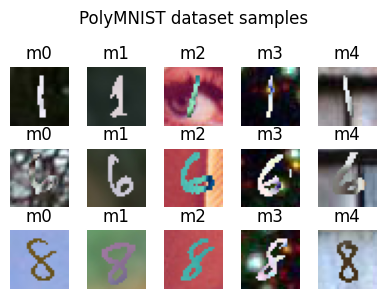

In [7]:
import torch
import matplotlib.pyplot as plt

# For the first 3 samples, we plot the images contained in each modality
fig, ax = plt.subplots(3,5, figsize=(4,3))

# Iterate on the datapoints
for i_sample in range(3):

    # Get the sample with index i_sample from train_dataset
    sample = train_dataset[i_sample]

    # For each of the five modalities, display the image
    for m, modality_name in enumerate(['m0','m1','m2','m3','m4']):

        # Get the modality tensor in sample.data
        sample_modality = sample.data[modality_name]

        # Transform it into an image we can display
        ndarr = sample_modality.mul(255).clamp_(0,255).int().permute(1,2,0).numpy()

        # Use the 'imshow' method to display the images
        ax[i_sample,m].imshow(ndarr)
        ax[i_sample,m].set_title(f'{modality_name}')
        ax[i_sample, m].set_axis_off()

print("Each line corresponds to a sample, and each column corresponds to a modality.")
plt.suptitle('PolyMNIST dataset samples')
plt.tight_layout()



Each multimodal sample in PolyMNIST is composed of five images, each containing a number. The backgrounds depend on the modality but the label of the
digit is the same in all modalities.

Now we will design a Multimodal Vae model for this dataset.
We will use the [MVTCAE](https://multivae.readthedocs.io/en/latest/models/multimodal_vaes/mvtcae.html) model that is easy to train and works pretty well on this dataset.

In [8]:
# First we import the model class and config from multivae
from multivae.models import MVTCAE, MVTCAEConfig

# TODO: Complete the model configuration.
# (help) https://multivae.readthedocs.io/en/latest/models/multimodal_vaes/mvtcae.html#multivae.models.MVTCAEConfig
# you can choose the latent dimension of your choice.

model_config = MVTCAEConfig(n_modalities = 5, latent_dim = 10)

print(f"My model has a latent dimension of {model_config.latent_dim}")

My model has a latent dimension of 10


Then, we should define an encoder and a decoder architecture for each modality.

Each encoder is a neural network that takes the modality data $X_m$ as input and returns $\mu(X_m)$ and $\Sigma(X_m)$ for sampling a latent code $q_{\phi(z|X_m)} = \mathcal{N}(\mu(X_m),\Sigma(X_m))$.

Each decoder is a neural network that takes the latent code $z$ as input and returns the reconstructed modality data $\hat{X_m}$.

Here we import simple convolution architectures from the library but you could define your own if you want to.



In [9]:
from multivae.models.nn.mmnist import EncoderConvMMNIST, DecoderConvMMNIST

# We define a dictionary with a convolutional encoder for each modality
encoders = {
    'm0' : EncoderConvMMNIST(model_config, bias=False),
    'm1' : EncoderConvMMNIST(model_config, bias=False),
    'm2' : EncoderConvMMNIST(model_config, bias=False),
    'm3' : EncoderConvMMNIST(model_config, bias=False),
    'm4' : EncoderConvMMNIST(model_config, bias=False)
}

# We define a dictionary with a convolutional decoder for each modality
decoders = {
    'm0' : DecoderConvMMNIST(model_config),
    'm1' : DecoderConvMMNIST(model_config),
    'm2' : DecoderConvMMNIST(model_config),
    'm3' : DecoderConvMMNIST(model_config),
    'm4' : DecoderConvMMNIST(model_config)
}

print(encoders['m0'])

EncoderConvMMNIST(
  (shared_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2048, out_features=10, bias=True)
    (8): ReLU()
  )
  (class_mu): Linear(in_features=10, out_features=10, bias=False)
  (class_logvar): Linear(in_features=10, out_features=10, bias=False)
)


Now we have everything we need to define and train the model.

In [10]:
from multivae.models import MVTCAE

# TODO: create a MVTCAE model with the model_config, encoders and decoders
model = MVTCAE(model_config, encoders, decoders) # TODO

# We use a trainer from the library
from multivae.trainers import BaseTrainer, BaseTrainerConfig

# TODO: create a BaseTrainerConfig with num_epochs=2
trainer_config = BaseTrainerConfig(num_epochs = 2) # TODO

trainer = BaseTrainer(model=model,
                      train_dataset=train_dataset,
                      eval_dataset=val_dataset,
                      training_config=trainer_config)

trainer.train()

Model passed sanity check !
Ready for training.

INFO:multivae.trainers.base.base_trainer:Model passed sanity check !
Ready for training.

Setting the optimizer with learning rate 0.0001
INFO:multivae.trainers.base.base_trainer:Setting the optimizer with learning rate 0.0001
Created dummy_output_dir folder since did not exist.

INFO:multivae.trainers.base.base_trainer:Created dummy_output_dir folder since did not exist.

Created dummy_output_dir/MVTCAE_training_2025-07-01_09-32-37. 
Training config, checkpoints and final model will be saved here.

INFO:multivae.trainers.base.base_trainer:Created dummy_output_dir/MVTCAE_training_2025-07-01_09-32-37. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 2
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-0

Training of epoch 1/2:   0%|          | 0/16 [00:00<?, ?batch/s]

Eval of epoch 1/2:   0%|          | 0/157 [00:00<?, ?batch/s]

New best model on eval saved!
INFO:multivae.trainers.base.base_trainer:New best model on eval saved!
--------------------------------------------------------------------------
INFO:multivae.trainers.base.base_trainer:--------------------------------------------------------------------------
Train loss: 12125.0274
INFO:multivae.trainers.base.base_trainer:Train loss: 12125.0274
Eval loss: 12082.2694
INFO:multivae.trainers.base.base_trainer:Eval loss: 12082.2694
--------------------------------------------------------------------------
INFO:multivae.trainers.base.base_trainer:--------------------------------------------------------------------------


Training of epoch 2/2:   0%|          | 0/16 [00:00<?, ?batch/s]

Eval of epoch 2/2:   0%|          | 0/157 [00:00<?, ?batch/s]

New best model on eval saved!
INFO:multivae.trainers.base.base_trainer:New best model on eval saved!
--------------------------------------------------------------------------
INFO:multivae.trainers.base.base_trainer:--------------------------------------------------------------------------
Train loss: 12027.7628
INFO:multivae.trainers.base.base_trainer:Train loss: 12027.7628
Eval loss: 11947.7832
INFO:multivae.trainers.base.base_trainer:Eval loss: 11947.7832
--------------------------------------------------------------------------
INFO:multivae.trainers.base.base_trainer:--------------------------------------------------------------------------
Training ended!
INFO:multivae.trainers.base.base_trainer:Training ended!
Saved final model in dummy_output_dir/MVTCAE_training_2025-07-01_09-32-37/final_model
INFO:multivae.trainers.base.base_trainer:Saved final model in dummy_output_dir/MVTCAE_training_2025-07-01_09-32-37/final_model


After training, you could easily reload the trained model from the checkpoint folder using the following code:
```
from multivae.models import AutoModel
trained_model = AutoModel.load_from_folder('path_to_checkpoint')
````

But in the rest of the tutorial, we will load fully trained models from Hugging Face Hub to avoid waiting for the model to train.

## Evaluating a trained model

In this section, we reload fully trained models from Hugging Face Hub and see how well they perform on different tasks.

We will look at different metrics:
 - **Reconstruction** : good reconstruction means that we have learned efficient latent representations
 - **Cross-Modal Generation** : Is our model good at generating missing modalities ?
 - **(Bonus) Clustering Metrics**: Is the multimodal latent representation useful for clustering ?

In [11]:
# Load a trained model : uncomment one of the lines to load a model
from multivae.models import AutoModel

# MVTCAE (Product of Experts with additional Total Correlation terms in the VAE loss)
model = AutoModel.load_from_hf_hub('asenella/MVTCAE_mmnist_python311', allow_pickle=True)
# MMVAE (Mixture of Experts)
# model = AutoModel.load_from_hf_hub('asenella/MMVAE_mmnist_python311', allow_pickle=True)
# MoPoE (Mixture of Product of Experts)
# model = AutoModel.load_from_hf_hub('asenella/MoPoE_mmnist_python311', allow_pickle=True)




INFO:multivae.models.auto_model.auto_model:Downloading config file ...


model_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

INFO:multivae.models.base.base_model:Downloading MVTCAE files for rebuilding...


environment.json:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

encoders.pkl:   0%|          | 0.00/43.9M [00:00<?, ?B/s]

Successfully downloaded encoders architecture.
INFO:multivae.models.base.base_model:Successfully downloaded encoders architecture.


decoders.pkl:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Successfully downloaded decoders architecture.
INFO:multivae.models.base.base_model:Successfully downloaded decoders architecture.
Successfully downloaded MVTCAE model!
INFO:multivae.models.base.base_model:Successfully downloaded MVTCAE model!


### Reconstruction
One thing we want to evaluate is the quality of the reconstruction.

If we take a multimodal sample $X$, encode it to obtain a latent code $z$ and decode this $z$, we should obtain a reconstructed sample $\hat{X}$ that is close to our original data. Good reconstructions mean that we have learned efficient latent embeddings $z$.

Below, we first visualize some reconstructions, then we compute average Mean Squared Error for all the reconstructions in the validation set.

In [ ]:
# Take 5 samples from the validation set
small_batch = val_dataset[:5]

# TODO: Using the 'encode' function of the model, compute the latent embeddings
# (help) : https://multivae.readthedocs.io/en/latest/models/multimodal_vaes/base.html#multivae.models.BaseMultiVAE.encode

embeddings = model.encode(small_bacth) # TODO
print(f"Latent codes have shape {embeddings.z.shape}")

# TODO: Using the 'decode' function of the model, compute the reconstructions
# (help) : https://multivae.readthedocs.io/en/latest/models/multimodal_vaes/base.html#multivae.models.BaseMultiVAE.encode
reconstructions = ... # TODO

print("Reconstructions are a dictionary containing the reconstructed tensor for each modality.")
print(f"The reconstruction for modality m0 has shape {reconstructions['m0'].shape}")


Latent codes have shape torch.Size([5, 512])
Reconstructions are a dictionary containing the reconstructed tensor for each modality.
The reconstruction for modality m0 has shape torch.Size([5, 3, 28, 28])


TODO: complete the code below to plot the original images versus the reconstructions.

Text(0.5, 0.98, 'Reconstructions')

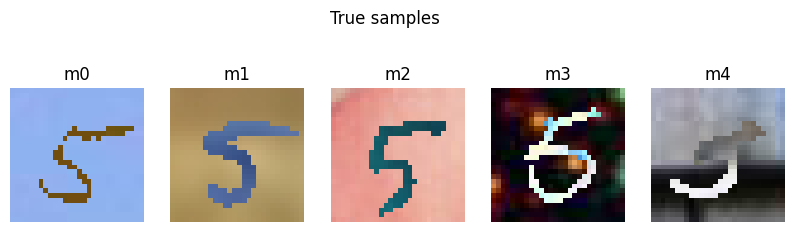

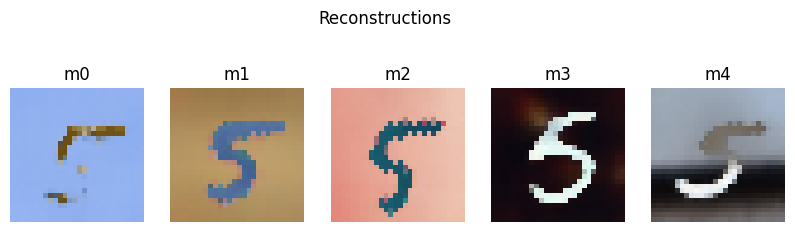

In [ ]:
# ORIGINAL IMAGES : Plot each modality image for the first sample
fig, ax = plt.subplots(1, 5, figsize=(10, 3))
for m, modality_name in enumerate(['m0','m1','m2','m3','m4']):

    # TODO: Get the modality tensor from small_batch.data
    batch_modality = ...

    # Keep only the first sample
    first_sample_modality = batch_modality[0]

    # Transform it into an image we can display
    ndarr = (
        first_sample_modality.mul(255).add_(0.5)
        .clamp_(0, 255)
        .permute(1, 2, 0)
        .to("cpu", torch.uint8)
        .numpy()
    )

    # Use the imshow methos to display the images
    ax[m].imshow(ndarr)
    ax[m].set_title(f'{modality_name}')
    ax[m].set_axis_off()

plt.suptitle('True samples')

# RECONSTRUCTIONS : Plot each modality for the first sample reconstruction
fig, ax = plt.subplots(1, 5, figsize=(10, 3))
for m, modality_name in enumerate(['m0','m1','m2','m3','m4']):

    # TODO: Get the modality tensor from the reconstructions dictionary
    reconstructions_modality = ...

    # Get only the first sample
    first_sample_reconstruction = reconstructions_modality[0]

    # Transform it into an image we can display
    ndarr = (
        first_sample_reconstruction.mul(255).add_(0.5)
        .clamp_(0, 255)
        .permute(1, 2, 0)
        .to("cpu", torch.uint8)
        .numpy()
    )

    # Use the imshow methos to display the images
    ax[m].imshow(ndarr)
    ax[m].set_title(f'{modality_name}')
    ax[m].set_axis_off()

plt.suptitle('Reconstructions')

*Remark*: In multivae, there is a method to plot reconstructions quicker: the *Visualization* class helps to evaluate the quality of produced images.

Reconstructions in the first modality


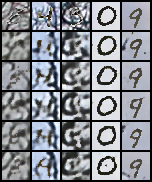

In [ ]:
from multivae.metrics import Visualization

visualisation_module = Visualization(model,val_dataset)

print("Reconstructions in the first modality")
visualisation_module.reconstruction('m0')

To evaluate **quantitatively** the reconstructions, we can compute the [MeanSquaredError](https://en.wikipedia.org/wiki/Mean_squared_error) between the original images and their reconstructions:

$$MSE(x,\hat{x}) = \frac{1}{N_{pixels}}\sum (x_i - \hat{x}_i)^2$$

In practice, we can compute it by using the [Reconstruction metric](https://multivae.readthedocs.io/en/latest/metrics/reconstruction.html) module.

In [ ]:
from multivae.metrics import Reconstruction, ReconstructionConfig
print("Let's compute the Mean Squared Error on the entire validation dataset!")

reconstruction_metric_config = ReconstructionConfig(
    batch_size=64, # We use a batch size of 64 to compute the metric
    metric='MSE' # We set here that the metric we want to evaluate is MSE. You can also evaluate SSIM.
)

# TODO: create a Reconstruction module and call eval() to compute the MSE
# on the entire validation dataset
# (help): https://multivae.readthedocs.io/en/latest/metrics/reconstruction.html



Let's compute the Mean Squared Error on the entire validation dataset!


Subset ['m0', 'm1', 'm2', 'm3', 'm4'] reconstruction : 40.449249267578125 
Subset ['m0', 'm1', 'm2', 'm3', 'm4'] reconstruction : 40.449249267578125 
INFO:2025-06-27_09-49-07:Subset ['m0', 'm1', 'm2', 'm3', 'm4'] reconstruction : 40.449249267578125 
Subset ['m0'] reconstruction : 69.88269805908203 
Subset ['m0'] reconstruction : 69.88269805908203 
INFO:2025-06-27_09-49-07:Subset ['m0'] reconstruction : 69.88269805908203 
Subset ['m1'] reconstruction : 31.650747299194336 
Subset ['m1'] reconstruction : 31.650747299194336 
INFO:2025-06-27_09-49-07:Subset ['m1'] reconstruction : 31.650747299194336 
Subset ['m2'] reconstruction : 38.43436813354492 
Subset ['m2'] reconstruction : 38.43436813354492 
INFO:2025-06-27_09-49-07:Subset ['m2'] reconstruction : 38.43436813354492 
Subset ['m3'] reconstruction : 75.01747131347656 
Subset ['m3'] reconstruction : 75.01747131347656 
INFO:2025-06-27_09-49-07:Subset ['m3'] reconstruction : 75.01747131347656 
Subset ['m4'] reconstruction : 37.3805427551269

### Imputing missing modalities
Now we want to see if our model is able to impute missing modalities given a set of observed modalities.

Recall that for generating missing modalities, we have to generate a latent $z$ using the encoders from *observed modalities* and then decode this $z$ to generate
the missing modality.

To quickly get a look at the model's performance for this task, we can use the [Visualization](https://multivae.readthedocs.io/en/latest/metrics/visualization.html) module. The module encodes the data, decodes in the missing modalities and shows the results.

Generations in modality 'm2' from observed modalities 'm0', 'm1'.


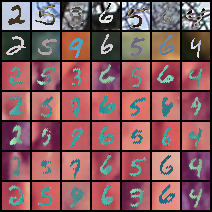

In [ ]:
from multivae.metrics import Visualization, VisualizationConfig

# TODO: instantiate the Visualization module with our model and val_dataset as test_dataset
# (help): https://multivae.readthedocs.io/en/latest/metrics/visualization.html

vis_module = ... # TODO

print("Generations in modality 'm2' from observed modalities 'm0', 'm1'.")
# TODO : generate the modality 'm2' from modalities 'm0','m1'. You can use the `conditional_from_subset` method.
# (help): https://multivae.readthedocs.io/en/latest/metrics/visualization.html



*Question*: how do the generated samples look ?

To have a quantitative evaluation of this conditional generations, there are two metrics we can use:
1. The ***coherence*** of the generations: with pretrained classifiers, we check if the generated modalities correspond to the same labels as the observed modalities.

2. The ***diversity*** of the generation: we compare the Fréchet Inception Distance between synthetic and real images. This metric is a proxy to evaluate the diversity and similarity between two sets of images.

Both those metrics are implemented in the multivae.metrics module.

First, we compute a coherence metric.

In [ ]:
import os
from multivae.metrics import CoherenceEvaluator, CoherenceEvaluatorConfig

# First we need to load the classifiers for evaluating coherence
from multivae.metrics.classifiers.mmnist import load_mmnist_classifiers
classifiers_path = os.path.join(data_path,'clf')
classifiers = load_mmnist_classifiers(classifiers_path)

# We instantiate a CoherenceEvaluator module for our model, test set and classifiers
coherence_module = CoherenceEvaluator(
    model=model,
    classifiers=classifiers,
    test_dataset=val_dataset
)

# TODO: evaluate the coherence of the model when generating samples from modalities [m0,m1] to other modalities
# you can use the `coherence_from_subset` method of the CoherenceEvaluator.
# (help): https://multivae.readthedocs.io/en/latest/metrics/coherences.html



Subset ['m0', 'm1'] accuracies 
Subset ['m0', 'm1'] accuracies 
INFO:2025-06-27_09-49-09:Subset ['m0', 'm1'] accuracies 
{'m0_m1_to_m2': tensor(0.8543), 'm0_m1_to_m3': tensor(0.7324), 'm0_m1_to_m4': tensor(0.7675)}
{'m0_m1_to_m2': tensor(0.8543), 'm0_m1_to_m3': tensor(0.7324), 'm0_m1_to_m4': tensor(0.7675)}
INFO:2025-06-27_09-49-09:{'m0_m1_to_m2': tensor(0.8543), 'm0_m1_to_m3': tensor(0.7324), 'm0_m1_to_m4': tensor(0.7675)}
Mean subset ['m0', 'm1'] accuracies : 0.7847092
Mean subset ['m0', 'm1'] accuracies : 0.7847092
INFO:2025-06-27_09-49-09:Mean subset ['m0', 'm1'] accuracies : 0.7847092


({'m0_m1_to_m2': tensor(0.8543), 'm0_m1_to_m3': tensor(0.7324), 'm0_m1_to_m4': tensor(0.7675)}, np.float32(0.7847092), array([0.8892508 , 0.9025641 , 0.7538126 , 0.78808707, 0.7972508 ,
       0.6951754 , 0.8479913 , 0.7705088 , 0.68098956, 0.7214611 ],
      dtype=float32))


We would expect that the more observed modalities we have, the more coherent are the generation.

Is it indeed the case for this model ?

Can you plot the evolution of the coherence given additional modalities ?

Subset ['m0'] accuracies 
Subset ['m0'] accuracies 
INFO:2025-06-27_09-49-09:Subset ['m0'] accuracies 
{'m0_to_m1': tensor(0.5370), 'm0_to_m2': tensor(0.5531), 'm0_to_m3': tensor(0.4910), 'm0_to_m4': tensor(0.5161)}
{'m0_to_m1': tensor(0.5370), 'm0_to_m2': tensor(0.5531), 'm0_to_m3': tensor(0.4910), 'm0_to_m4': tensor(0.5161)}
INFO:2025-06-27_09-49-09:{'m0_to_m1': tensor(0.5370), 'm0_to_m2': tensor(0.5531), 'm0_to_m3': tensor(0.4910), 'm0_to_m4': tensor(0.5161)}
Mean subset ['m0'] accuracies : 0.52428824
Mean subset ['m0'] accuracies : 0.52428824
INFO:2025-06-27_09-49-09:Mean subset ['m0'] accuracies : 0.52428824
Subset ['m0', 'm1'] accuracies 
Subset ['m0', 'm1'] accuracies 
INFO:2025-06-27_09-49-09:Subset ['m0', 'm1'] accuracies 
{'m0_m1_to_m2': tensor(0.8484), 'm0_m1_to_m3': tensor(0.7625), 'm0_m1_to_m4': tensor(0.7723)}
{'m0_m1_to_m2': tensor(0.8484), 'm0_m1_to_m3': tensor(0.7625), 'm0_m1_to_m4': tensor(0.7723)}
INFO:2025-06-27_09-49-09:{'m0_m1_to_m2': tensor(0.8484), 'm0_m1_to_m3'

Text(0.5, 1.0, 'Coherence as a function of the number of modalities for model MVTCAE')

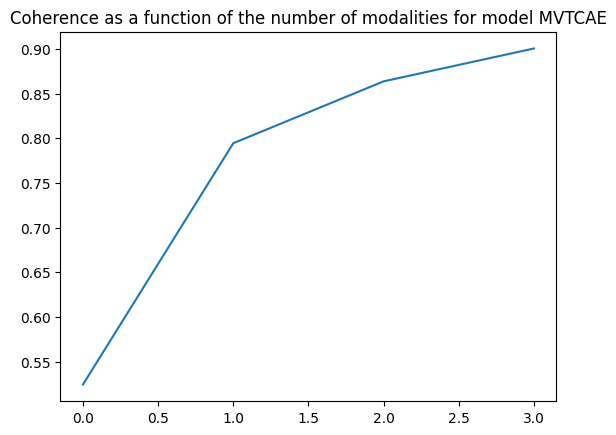

In [ ]:
observed_modalities = [['m0'], ['m0','m1'],['m0','m1','m2'],['m0','m1','m2','m3']]
mean_coherences = []

# TODO : compute the mean coherences for each of observed subset and plot the
# curve of the coherence as a function of the number of observed modalities.



Question: Does the coherence indeed improves the more modalities we observe ? If not, do you have an idea why ?

(Optional) : In addition to the coherence, we can compute the [FID](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance) of the generations. This goal for this score is to measure the diversity of generated samples. The lower it is, the more diverse the generations.

You can run the code below to compute the FID for generated images. However it takes some time to compute.

In [ ]:
from multivae.metrics import FIDEvaluator, FIDEvaluatorConfig
import os

# Load FID weights
fid_path = os.path.join(data_path,'pt_inception-2015-12-05-6726825d.pth')

# Instantiate a FIDEvaluator module
fid_module = FIDEvaluator(model,val_dataset,eval_config=FIDEvaluatorConfig(batch_size=16,inception_weights_path=fid_path))

# Compute the FID when generating the m2 modality from [m0,m1]
print('Computing FID. This could take a while.')
fid_module.compute_fid_from_conditional_generation(['m0','m1'], gen_mod='m2')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Computing FID. This could take a while.


100%|██████████| 188/188 [00:21<00:00,  8.60it/s]
The FD for modality m2 computed from subset=['m0', 'm1'] is 84.40466837566686
INFO:2025-06-27_09-49-11:The FD for modality m2 computed from subset=['m0', 'm1'] is 84.40466837566686


np.float64(84.40466837566686)

TODO: Complete the table below with your observations. If you have the time at the end of the session, you can rerun the code with the other models to see how they compare.

| Model | MSE (joint)| Coherence (from m0,m1)|FID| Coherence improves with the number of observed modalities ? |
|-------|------------|-----------------------|---|-----------------------------------------|
|MVTCAE |            |                       |   |                          |
|MMVAE  |            |                       |   |                          |
|MoPoE  |            |                       |   |                          |


At the end of this notebook, you can also evaluate the relevance of each model for clustering tasks.

## Data Augmentation: generating fully synthetic multimodal samples

In the section above, we used multimodal VAEs to generate **missing modalities from observed ones**.
But these models could also be used to generate **fully synthetic multimodal samples**.
These technique can be used to *augment* a small size dataset as done in [this article](https://ieeexplore.ieee.org/abstract/document/9806307) to improve performance on a downstream task such as classification, segmentation etc...

The most natural way to generate fully synthetic samples is to first sample a latent code from the prior distribution
$$z \sim p(z) = \mathcal{N}(0,I)$$
and then decode this $z$ in each modality.

We first look at the results we obtain with this method and then consider more advanced methods.

The shape of the generations in m0 modality is torch.Size([5, 3, 28, 28])


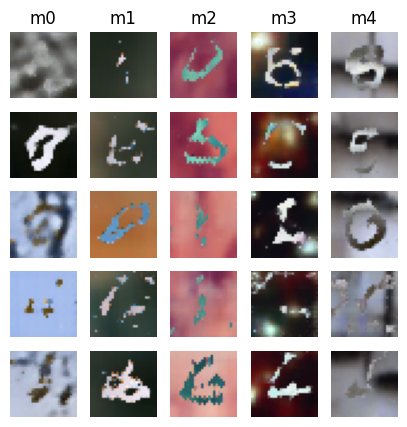

In [ ]:
# Generate latent codes from the prior.
n_samples = 5
latent_codes = model.generate_from_prior(n_samples)

# TODO: Decode these samples to generate multimodal images
generations = ...
print(f"The shape of the generations in m0 modality is {generations['m0'].shape}")

# Plot the generations
fig, ax = plt.subplots(n_samples,5, figsize=(5,5))
for i in range(n_samples):
    for m, modality_name in enumerate(model.modalities_name):

        modality_generation = generations[modality_name][i]

        # Transform the image to display it
        modality_image = modality_generation.mul(255).add_(0.5).clamp_(0,255).int().permute(1,2,0).cpu().numpy()
        if i==0:
            ax[i,m].set_title(modality_name)
        ax[i,m].imshow(modality_image)
        ax[i,m].set_axis_off()



As we can see, this method doesn't give very good results because in practice the **latent codes $z$ distribution don't match the prior distribution**.
To improve these unconditional generations, we can try to approximate *a posteriori* the distribution of the latent codes.

For instance, we can fit a [Gaussian Mixture Model](https://scikit-learn.org/stable/modules/mixture.html) on the embeddings of the training set and sample new latent codes from this distribution.
<center>
 <img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_gmm_pdf_001.png" alt="Girl in a jacket" width="300" >

For this we can use the [GaussianMixtureSampler](https://multivae.readthedocs.io/en/latest/samplers/gmm.html) from the library.

In [ ]:
from multivae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

# TODO: Define a GaussianMixtureSampler with 10 components
# (help): https://multivae.readthedocs.io/en/latest/readme.html#using-samplers

sampler_config = ...
sampler = ...

# We fit the sampler on the training set
# The GaussianMixtureSampler computes all the embeddings for the training set and then fit a GMM model on them.
sampler.fit(train_dataset)

Once the Gaussian Mixture is fit, we can sample latent codes from it.

The shape of the generations in m0 modality is torch.Size([5, 3, 28, 28])


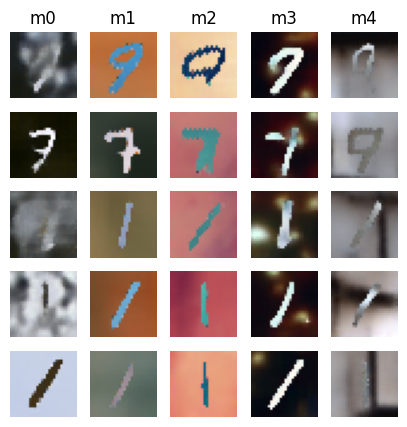

In [ ]:
# TODO: use the `sample` method of the trained sampler to generate 5 latent codes
latent_codes = ...

# TODO: Decode these latent codes and plot the generated images
generations = ...
print(f"The shape of the generations in m0 modality is {generations['m0'].shape}")

# Plot the generations
fig, ax = plt.subplots(n_samples,5, figsize=(5,5))
for i in range(n_samples):
    for m, modality_name in enumerate(model.modalities_name):

        modality_generation = generations[modality_name][i]

        # Transform the image to display it
        modality_image = modality_generation.mul(255).add_(0.5).clamp_(0,255).int().permute(1,2,0).cpu().numpy()
        if i==0:
            ax[i,m].set_title(modality_name)
        ax[i,m].imshow(modality_image)
        ax[i,m].set_axis_off()


Question : how are the generations ?

Note that the Visualization Module and CoherenceEvaluator can also be used with the sampler for fast evaluation of the synthetic samples.

In [ ]:
# Compute the coherence of fully synthetic samples generated with our Gaussian Mixture
# We pass the sampler as an argument
print('Coherence of samples generated from the prior:')
CoherenceEvaluator(model, classifiers, val_dataset).joint_coherence()

print(f'Coherence of samples generated from the {sampler.name}:')
CoherenceEvaluator(model, classifiers, val_dataset, sampler=sampler).joint_coherence()



Coherence of samples generated from the prior:


Joint coherence with sampler prior: tensor(0.0675, device='cuda:0')
INFO:2025-06-27_09-48-10:Joint coherence with sampler prior: tensor(0.0675, device='cuda:0')


Coherence of samples generated from the GaussianMixtureSampler:


Joint coherence with sampler GaussianMixtureSampler: tensor(0.1835, device='cuda:0')
Joint coherence with sampler GaussianMixtureSampler: tensor(0.1835, device='cuda:0')
INFO:2025-06-27_09-48-10:Joint coherence with sampler GaussianMixtureSampler: tensor(0.1835, device='cuda:0')


tensor(0.1835, device='cuda:0')

Here we used a Gaussian Mixture but there are other sampling methods we can use.

You can replace the GaussianMixtureSampler by one of the following and see the results !

- [MAFSampler](https://multivae.readthedocs.io/en/latest/samplers/maf.html): Fit a masked autoregressive flow to the latent embeddings and sample from it.
- [IAFSampler](https://multivae.readthedocs.io/en/latest/samplers/iaf.html): Fit an inverse autoregressive flow to the latent embeddings and sample from it.

**Key take-away**: for generating fully synthetic multimodal samples, modelling a posteriori the distribution of the latent codes can be very powerful!


In [ ]:
# TODO: choose another sampler, compute visualizations and coherence of fully synthetic samples

# What's next ?

If you finished super early and you want to do the bonus part, you can look at clustering metrics for your model in the section below.

- **To know more about the different multimodal VAEs methods** that exists, you can look at this [survey paper](https://arxiv.org/abs/2207.02127). Short descriptions of models are also available in MultiVae's [documentation](https://multivae.readthedocs.io/en/latest/models/multivae.models.html).

- **Which model should I use in my application ?** : This [benchmark case study](https://github.com/AgatheSenellart/MultiVae/blob/main/examples/case_studies/benchmarking_on_partial_polymnist/results.md) can help you decide. Note that many models can be trained on **incomplete datasets** including the ones used in this tutorial.

- **What are the medical applications of multimodal VAEs ?** : These models can be used to generate synthetic medical images as done in [(Reuben et al, 2025)](https://arxiv.org/abs/2309.08747), to augment or complete a dataset, or for **anomaly detection** as done in [(Aguila et al 2023)](https://arxiv.org/abs/2303.12706) and [(Kumar et al, 2024)](https://www.biorxiv.org/content/10.1101/2024.12.12.628273v1.full.pdf).

### Bonus part: clustering

In this part, we look more closely at the latent codes and see if we can do easy clustering of the data on them.
Remember that our data is composed of multimodal images of digits from 0 to 10. Therefore we can see if we retrieve these 10 categories when we perform clustering on the data.

The module multivae.metrics.Clustering allows easy clustering on the latent embeddings using a K-means algorithm.

TODO: using this module and the documentation of this module, can you perform clustering on the latent embeddings and return the K-means accuracy of the model ?

In [ ]:
from multivae.metrics import Clustering, ClusteringConfig

# TODO: use the Clustering module to cluster the latent codes in 10 clusters
# (help) : https://multivae.readthedocs.io/en/latest/metrics/clustering.html



Cluster accuracy is 0.8
INFO:2025-06-27_09-49-53:Cluster accuracy is 0.8


ModelOutput([('cluster_accuracy', np.float64(0.8))])